In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import torch

from gpdm import GPDM
from mocap_labels import WALK_TRIALS, RUN_TRIALS

<frozen importlib._bootstrap>:488: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


pygame 2.6.1 (SDL 2.30.7, Python 3.12.6)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [4]:
print(f"Number of walk trials: {len(WALK_TRIALS)}")
print(f"Number of run trials: {len(RUN_TRIALS)}")

Number of walk trials: 31
Number of run trials: 27


In [5]:
walk_dfs = [trial.as_dataframe() for trial in WALK_TRIALS]
run_dfs = [trial.as_dataframe() for trial in RUN_TRIALS]

walk_arrs = [df.drop(['time', 'frame'], axis=1).to_numpy().astype(np.float32) for df in walk_dfs]
run_arrs = [df.drop(['time', 'frame'], axis=1).to_numpy().astype(np.float32) for df in run_dfs]

In [13]:
D = walk_arrs[0].shape[1]   # Observation space dimension
d = 3                       # Latent space dimension
print(D)

# Initial values for hyperparameters
y_lambdas_init = np.ones(D)  # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)  # Lengthscales for observation GP
y_sigma_n_init = 1e-2  # Noise standard deviation for observation GP

x_lambdas_init = np.ones(d)  # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(2*d)  # Lengthscales for latent dynamics GP (since dyn_back_step = 2)
x_sigma_n_init = 1e-2  # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(2*d + 1)  # Linear coefficients for latent dynamics GP


62


In [7]:
# Create GPDM object
walk_gpdm = GPDM(D=D, d=d, 
                  dyn_target='full', dyn_back_step=2, 
                  y_lambdas_init=y_lambdas_init,
                  y_lengthscales_init=y_lengthscales_init, 
                  y_sigma_n_init=y_sigma_n_init, 
                  x_lambdas_init=x_lambdas_init, 
                  x_lengthscales_init=x_lengthscales_init, 
                  x_sigma_n_init=x_sigma_n_init, 
                  x_lin_coeff_init=x_lin_coeff_init, 
                  flg_train_y_lambdas=True, 
                  flg_train_y_lengthscales=True, 
                  flg_train_y_sigma_n=True, 
                  flg_train_x_lambdas=True, 
                  flg_train_x_lengthscales=True, 
                  flg_train_x_sigma_n=True, 
                  flg_train_x_lin_coeff=True, 
                  sigma_n_num_Y=0., 
                  sigma_n_num_X=0., 
                  dtype=torch.float64, 
                  device=torch.device('cpu'))

In [8]:
for walk_arr in walk_arrs:
    walk_gpdm.add_data(walk_arr)

print('Num. of sequences = '+str(walk_gpdm.num_sequences)+' [Data points = '+str(np.concatenate(walk_gpdm.observations_list, 0).shape[0])+']')


Num. of sequences = 31 [Data points = 11957]


In [9]:
walk_gpdm.init_X()  
walk_gpdm.train_adam(num_opt_steps=1, num_print_steps=1, lr=0.01)

walk_gpdm.save('walk_gpdm_config.pth', 'walk_gpdm_state.pth')  


### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 1.6679e+08
Update time: 1260.1364748477936

GPDM config dict saved in walk_gpdm_config.pth
GPDM state dict saved in walk_gpdm_state.pth


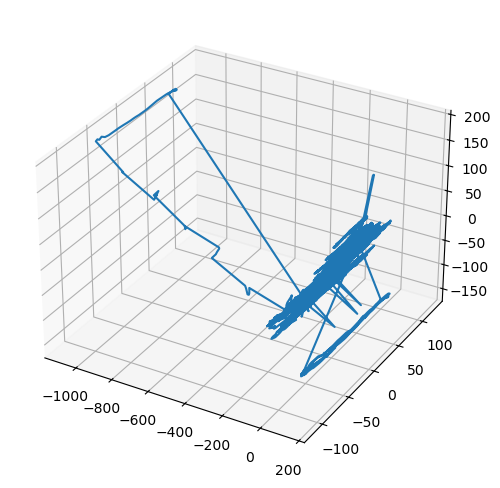

In [12]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X = walk_gpdm.X.detach().numpy()
ax.plot(X[:, 0], X[:, 1], X[:, 2])